### Autoencoders 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import sklearn
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import inspect

In [2]:
torch.manual_seed(0)

In [3]:
config = {"input_size" : 784,
"h1" : 512,
"h2" : 256,
"bottleneck" : 128,
"h3" : 256,
"h4" : 512,
"lr" : 0.001,
"number_epoch" : 100,
"batch_size" : 100}
# works better then 784 - 284 - 128

In [4]:
class Noisify:
    def __init__(self, noise_level):
        self.noise_level = noise_level
    def __call__(self, sample):
        if len(sample) > 0:
            clean_image = sample[0]
        else:
            raise ValueError("Sample is empty!")
        noise = self.noise_level * np.random.normal(0, 1, size=clean_image.shape)
        noisy_image = clean_image + noise
        all_images = (noisy_image, clean_image)
        return all_images

In [ ]:
transformation = transforms.Compose([transforms.ToTensor(),  Noisify(0.15)])


train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transformation, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transformation, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=config["batch_size"], shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=config["batch_size"], shuffle=False)

In [6]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_size, h1, h2, bottleneck, h3, h4):

        super(DenoisingAutoencoder, self).__init__()
        
        self.encoding_layers = nn.Sequential(
            nn.Linear(input_size, h1),
            nn.ReLU(),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Linear(h2, bottleneck)
        )

        self.decoding_layers = nn.Sequential(
            nn.Linear(bottleneck, h3),
            nn.ReLU(),
            nn.Linear(h3, h4),
            nn.ReLU(),
            nn.Linear(h4, input_size)
        )  
    def encoder_forward(self, noisy_image):

        out = self.encoding_layers(noisy_image)
        return out
    
    def decoder_forward(self, encoded_forward):

        out = self.decoding_layers(encoded_forward)
        return out
    
    def forward(self, noisy_image):

        encoder_forward = self.encoder_forward(noisy_image)
        decoded_forward = self.decoder_forward(encoder_forward)
        return decoded_forward

In [7]:
class Model_Trainer:
    def __init__(self, config, train_loader):
        self.train_loader = train_loader
        self.config = config
        self.losses = []

        # not my code next two lines from online 
        sig = inspect.signature(DenoisingAutoencoder.__init__)
        keys_list = [key for key in sig.parameters.keys() if key != 'self']
        
        if not set(keys_list).issubset(config):
            missing = [key for key in keys_list if key not in config]
            raise KeyError(f"You are missing {missing} key")
        
        self.model = DenoisingAutoencoder(*[config[key] for key in keys_list])

        self.cost = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.config["lr"])

    def fit(self): 
        for epoch in range(self.config["number_epoch"]):
            epoch_loss = []
            for (i, ((noisy_image, clean_image), label) )in enumerate(self.train_loader):       
                #Forward pass
                noisy_image, clean_image = noisy_image.reshape(-1, self.config["input_size"]), clean_image.reshape(-1, self.config["input_size"])

                noisy_image = noisy_image.type(torch.float32)
                clean_image = clean_image.type(torch.float32)

                output = self.model.forward(noisy_image)
                loss = self.cost(output, clean_image)
                self.losses.append(loss.item())
                epoch_loss.append(loss.item())
                #backpropogation

                loss.backward()
                self.optimizer.step() 
                self.optimizer.zero_grad()

                avg_loss = sum(epoch_loss) / len(epoch_loss)
                if i % 100 == 0:
                    print(f'Epoch [{epoch+1}/{self.config["number_epoch"]}], Avg Loss: {avg_loss:.6f}')

In [ ]:
trainer = Model_Trainer(config, train_loader)
trainer.fit()

In [9]:

model = trainer.model

In [10]:
def Denoise(model, noisy_image):
    with torch.no_grad():
        noisy_image =  noisy_image.reshape(-1, config["input_size"])
        noisy_image = noisy_image.type(torch.float32)
        output = model.forward(noisy_image)
        output = output.reshape(28, 28)
        output = output.detach().numpy()
    return output 

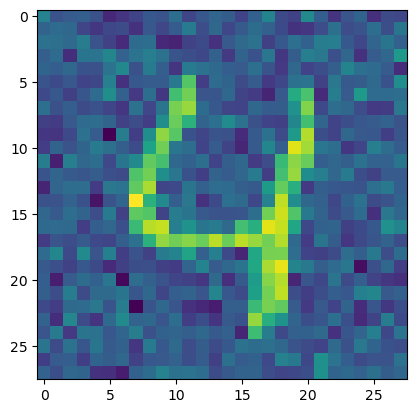

In [14]:
(noisy_image, clean_image), label = next(iter(test_loader))
plt.imshow(noisy_image[4])


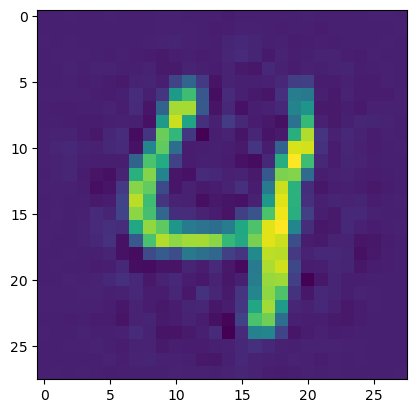

In [16]:
test_image = noisy_image[4]
cleaned_test_image = Denoise(model, test_image)
plt.imshow(cleaned_test_image)